In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import ipyvolume as ipv
import pathlib, glob

In [4]:
import sys
sys.path.append('../src/')
from forward_modeling import project_volume, slice_volume
from scipy.interpolate import RegularGridInterpolator, griddata

Make sure we have a local directory to read the data from, and that the data is there

In [5]:
data_directory = pathlib.Path('..') / 'data'  # directory where the data is
output_dir = data_directory / 'test'
if output_dir.exists():
    print(f'Data directory {output_dir} exists: ')
    for x in list(output_dir.glob('*')):
        print(f'>>> {str(x)}') 

Data directory ../data/test exists: 
>>> ../data/test/particle_hires_xyz.npy
>>> ../data/test/particle_hires_map.npy
>>> ../data/test/particle_meta.npy
>>> ../data/test/particle_hires_data.npy
>>> ../data/test/particle_hires_meta.npy
>>> ../data/test/particle_map.npy
>>> ../data/test/particle_xyz.npy
>>> ../data/test/particle_data.npy


Pick a dataset by its keyword

In [58]:
keyword='particle'
dataset     = np.load(f'{output_dir}/{keyword}_data.npy')
metadataset = np.load(f'{output_dir}/{keyword}_meta.npy')
volume      = np.load(f'{output_dir}/{keyword}_map.npy')
structure   = np.load(f'{output_dir}/{keyword}_xyz.npy')

Let's have a look at the structure

In [6]:
ipv.quickscatter(structure[:,0], structure[:,1], structure[:,2], size=10*structure[:,3], marker='sphere')

Now let's check the volume

In [7]:
ipv.quickvolshow(volume, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

/Users/fpoitevi/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipyvolume/serialize.py:92: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0] ** 2 + gradient[1] ** 2 + gradient[2] ** 2)


And now a few of the projection images

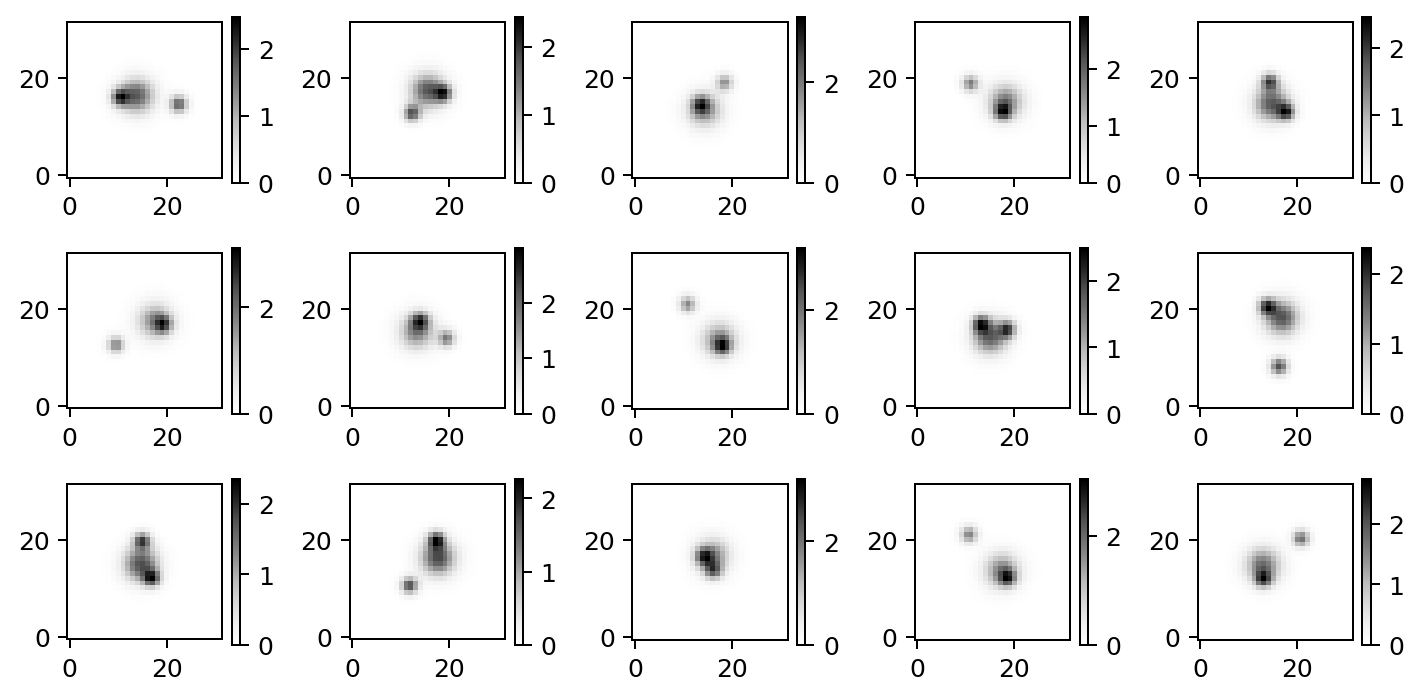

In [8]:
nrows=3
ncols=5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,4), dpi=180)
k=0
for i in np.arange(nrows):
    for j in np.arange(ncols):
        #axes[i,j].plot(metadataset[k,0:3])
        ax = axes[i,j]
        ims = ax.imshow(dataset[k], cmap='Greys', origin='lower')
        fig.colorbar(ims, ax=ax)
        k+=1
plt.tight_layout()
plt.show()

# Projections
We now look into projections where instead of rotation the particle, we rotate the slicing plane

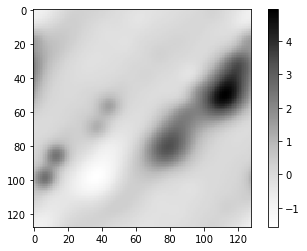

In [6]:
#Rot = R.random(random_state = 0)
#Rot = R.from_euler('x', 0, degrees = True)
Rot = R.from_rotvec(metadataset[0,0:3])
projection = project_volume(volume, Rot)
plt.imshow(projection, cmap='Greys')
plt.colorbar()

In [12]:
#Note from Fred: j'en suis la. J'ai pas eu le temps de finir...

Si j'essaie avec la slice à x=0

In [ ]:
slice_ = (vol_shift[16, :, :] + vol_shift[17, :, :])/2
slice_ = np.fft.ifftshift(slice_)
im = np.fft.ifft2(slice_)
plt.imshow(np.real(im))

In [ ]:
plt.imshow(np.sum(volume, axis = 0))

In [62]:
def backprojection1(images, orientations):
    """
    backprojection with conventional method (the orientations are assigned)
    """
    N = images[0].shape[0]
    dico = {}
    index_images = np.arange(len(images))
    index = np.arange(N)
    for n in index_images:
        rot = R.from_rotvec(-orientations[n]) #transpose
        for i in index:
            x = -1 + i*2/(N-1)
            for j in index:
                y = -1 + j*2/(N-1)
                vect = np.array((x,y,0))
                vect_ = rot.apply(vect)
                key = np.array2string(vect_, precision=3, separator=',', suppress_small=True)
                if key in dico.keys():
                    dico[key][0] += images[n][i,j]
                    dico[key][1] +=1
                else:
                    dico[key] = np.array((images[n,i,j], 1))
    points = np.zeros((len(dico), 3))
    values = np.zeros(len(dico))
    ctr = 0
    for keys in dico.keys():
        points[ctr] = eval('np.array(' + keys + ')')
        values[ctr] = dico[keys][0] / dico[keys][1]
        ctr+=1
    
    grid_x, grid_y, grid_z = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N),np.linspace(-1,1,N))

    volume = griddata(points, values, (grid_x, grid_y, grid_z))
    return volume

In [67]:
def reconstruct(dataset, V_0, sigma_0=0, tau_0=0):
    return 

In [64]:
vo = backprojection1(dataset, metadataset[:,:3])

In [65]:
ipv.quickvolshow(vo, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

In [66]:
ipv.quickvolshow(volume, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

In [7]:
def project_volume_bis(volume, Rotation):
    N = volume.shape[0]
    volume_ = np.zeros((N,N), dtype=np.complex_)
    x = np.linspace(-1,1,N)
    y = np.linspace(-1,1,N)
    z = np.linspace(-1,1,N)
    interpolating_function = RegularGridInterpolator(points=[x,y,z],values=volume,bounds_error = False, fill_value=0)

    grid_x, grid_y,grid_z  = np.meshgrid(x,y,z, indexing='ij')
    points = np.stack([grid_x.ravel(),grid_y.ravel(), grid_z.ravel()],1)
    rot_points = Rotation.apply(points)

    volume_ = interpolating_function(rot_points)
    return volume_.reshape((N,N,N), order='C')

[-0.0180708  -0.76711756  2.8390745 ]


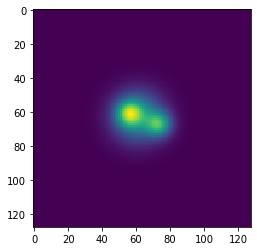

In [52]:
i=40
Rotation = (R.from_rotvec(-metadataset[i,0:3]))
print(Rotation.as_euler('zyx'))

volume_ = project_volume_bis(volume, Rotation)

im = np.sum(volume_, axis=2)
plt.imshow(dataset[i])

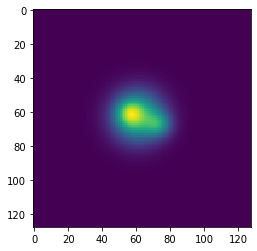

In [53]:
plt.imshow(im)